# 고장시점 회귀분석

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection #import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn import metrics  # mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, r2_score
from sklearn.feature_selection import SelectFromModel, RFECV

# 데이터

In [2]:
df_train = pd.read_csv('PM_train_pre.csv')
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0


In [3]:
df_test = pd.read_csv('PM_test_pre.csv')
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138,0,0


In [4]:
features = ['setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
features_sensors = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

X_train = df_train[features]
y_train = df_train['ttf']

X_test = df_test[features]
y_test = df_test['ttf']

# 회귀분석 성능 지표

In [5]:
def get_regression_metrics(model, actual, predicted):
    regr_metrics = {
      'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
      'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
      'R^2' : metrics.r2_score(actual, predicted)}

    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

## 상관 계수와 중요 특성값

In [6]:
def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

## 잔차를 그리는 함수

In [7]:
def plot_residual(model, y_train, y_train_pred, y_test, y_test_pred):
    plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data', s=2)
    plt.scatter(y_test_pred, y_test_pred - y_test, c='lightgreen', marker='s', label='Test data', s=2)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=-50, xmax=400, color='red', lw=2)
    plt.title(model + ' Residuals')
    plt.show()

# 회귀 분석
## 선형 모델

In [8]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)

y_test_predict = linreg.predict(X_test)
y_train_predict = linreg.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

linreg_metrics = get_regression_metrics('Linear Regression', y_test, y_test_predict)
linreg_metrics


R^2 training: 0.580, R^2 test: 0.327


,Linear Regression
Root Mean Squared Error,48.399484
Mean Absolute Error,37.173907
R^2,0.326553


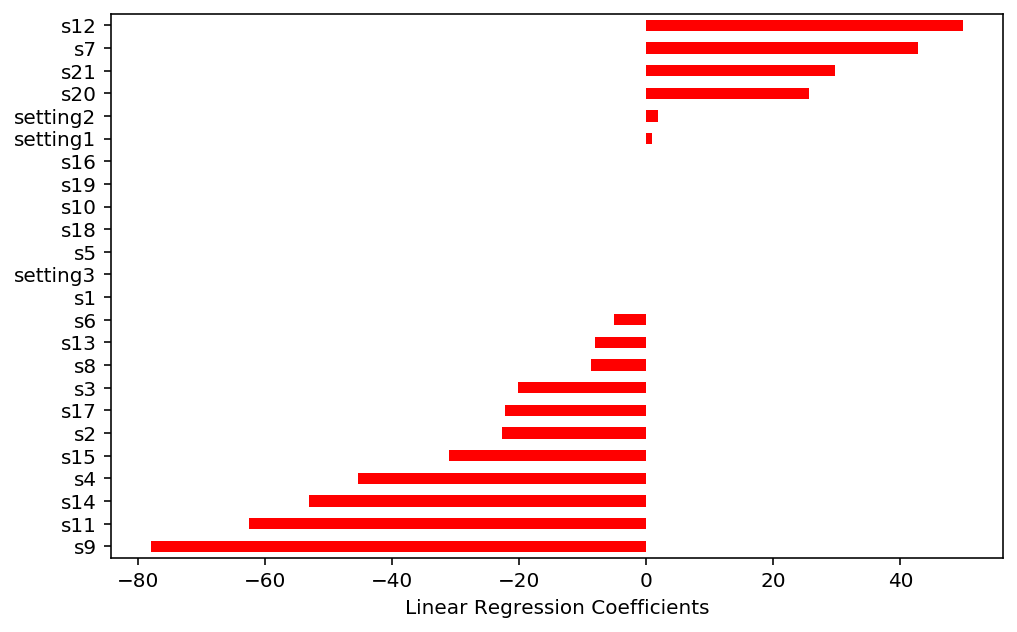

In [16]:
plot_features_weights('Linear Regression', linreg.coef_, X_train.columns, 'c')

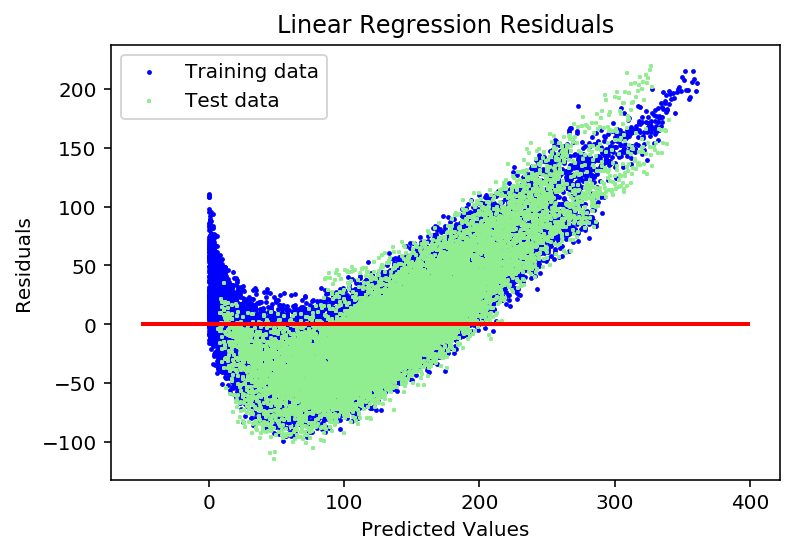

In [9]:
plot_residual('Linear Regression', y_train_predict, y_train, y_test_predict, y_test)

## 다차항 모델

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)

y_test_predict = polyreg.predict(X_test_poly)
y_train_predict = polyreg.predict(X_train_poly)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

polyreg_metrics = get_regression_metrics('Polynomial Regression', y_test, y_test_predict)
polyreg_metrics

R^2 training: 0.627, R^2 test: 0.374


,Polynomial Regression
Root Mean Squared Error,46.662878
Mean Absolute Error,35.307453
R^2,0.374013


In [11]:
X_train.shape, X_train_poly.shape

((20631, 24), (20631, 325))

In [15]:
# plot_residual('Polynomial Regression', y_train_predict, y_train, y_test_predict, y_test)

- Polynomial 회귀의 성능이 선형 모델보다 더 낫다

## 랜덤 포레스트

In [12]:
rf = RandomForestRegressor(n_estimators=100) # original features

rf.fit(X_train, y_train)

y_test_predict = rf.predict(X_test)
y_train_predict = rf.predict(X_train)

print('R^2 training: %.3f, R^2 test: %.3f' % (
      (metrics.r2_score(y_train, y_train_predict)), 
      (metrics.r2_score(y_test, y_test_predict))))

rf_metrics = get_regression_metrics('Random Forest Regression', y_test, y_test_predict)
rf_metrics

R^2 training: 0.949, R^2 test: 0.381


,Random Forest Regression
Root Mean Squared Error,46.401933
Mean Absolute Error,35.090494
R^2,0.380995


In [17]:
# plot_features_weights('Random Forest Regressor', rf.feature_importances_, X_train.columns, 't' )

In [18]:
# plot_residual('Random Forest Regression', y_train_predict, y_train, y_test_predict, y_test)

### 실제값과 예측치 보기

In [13]:
rf_pred_dict = {
    'Actual' : y_test,
    'Prediction' : y_test_predict }
    
rf_pred = pd.DataFrame.from_dict(rf_pred_dict).T
rf_pred[:20].T

,Actual,Prediction
0,142.0,178.53
1,141.0,166.58
2,140.0,163.37
3,139.0,168.25
4,138.0,191.69
...,...,...
13091,24.0,20.90
13092,23.0,25.07
13093,22.0,24.85
13094,21.0,23.20


In [14]:
X_test[:3]

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348


In [ ]:
# !pip install tensorflow
# !pip install keras

## MLP 사용

In [62]:
from keras import Sequential
from keras.layers import Dense

model = Sequential()
# model.add(Dense(300, activation='relu', input_dim=24)) 
model.add(Dense(300, activation='relu', input_shape=(24,)) 
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(1))

In [60]:
import keras

In [63]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, batch_size=20, epochs=20,
                validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Train on 16504 samples, validate on 4127 samples
Epoch 1/20
16504/16504 [==============================] - 7s 405us/step - loss: 1938.9327 - val_loss: 2549.8473
Epoch 2/20
16504/16504 [==============================] - 7s 405us/step - loss: 1591.5018 - val_loss: 2655.1156
Epoch 3/20
16504/16504 [==============================] - 6s 382us/step - loss: 1560.1203 - val_loss: 2434.9448
Epoch 4/20
16504/16504 [==============================] - 6s 392us/step - loss: 1543.3188 - val_loss: 2557.2571
Epoch 5/20
16504/16504 [==============================] - 6s 386us/step - loss: 1521.1197 - val_loss: 2558.5401
Epoch 6/20
16504/16504 [==============================] - 6s 378us/step - loss: 1519.1213 - val_loss: 2515.8558
Epoch 7/20
16504/16504 [==============================] - 6s 384us/step - loss: 1505.0464 - val_loss: 2911.5890
Epoch 8/20
16504/16504 [==============================] - 7s 395us/step - loss: 1507.2990 - val_loss: 2604.0634


In [64]:
y_pred = model.predict(X_test)
metrics.r2_score(y_test, y_pred)

0.4086621368135249

In [65]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=24)) 
model.add(Dense(100, activation='relu'))
model.add(Dense(1))

In [69]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               2500      
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 12,701
Trainable params: 12,701
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss='mse',optimizer='adam')
history = model.fit(X_train, y_train, batch_size=20, epochs=20,
                validation_split=0.2, verbose=1,
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

Train on 16504 samples, validate on 4127 samples
Epoch 1/20
16504/16504 [==============================] - 3s 195us/step - loss: 2240.6450 - val_loss: 2776.3034
Epoch 2/20
16504/16504 [==============================] - 2s 144us/step - loss: 1610.5961 - val_loss: 2607.7116
Epoch 3/20
16504/16504 [==============================] - 2s 148us/step - loss: 1581.8080 - val_loss: 2570.3569
Epoch 4/20
16504/16504 [==============================] - 2s 146us/step - loss: 1568.1281 - val_loss: 2579.6127
Epoch 5/20
16504/16504 [==============================] - 2s 144us/step - loss: 1554.5609 - val_loss: 2822.8091
Epoch 6/20
16504/16504 [==============================] - 3s 164us/step - loss: 1533.0707 - val_loss: 2707.0708
Epoch 7/20
16504/16504 [==============================] - 3s 159us/step - loss: 1527.6644 - val_loss: 2701.9640
Epoch 8/20
16504/16504 [==============================] - 3s 154us/step - loss: 1510.3629 - val_loss: 2635.0914


In [67]:
y_pred = model.predict(X_test)
metrics.r2_score(y_test, y_pred)

0.3906243080667574